<a href="https://colab.research.google.com/github/bertagrim/fastai_practice/blob/main/image_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 5.3 MB/s 
     |████████████████████████████████| 1.2 MB 43.7 MB/s 
     |████████████████████████████████| 189 kB 50.6 MB/s 
     |████████████████████████████████| 46 kB 3.0 MB/s 
     |████████████████████████████████| 56 kB 4.8 MB/s 
     |████████████████████████████████| 51 kB 381 kB/s 
Mounted at /content/gdrive


In [3]:
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

In [4]:
from ipywidgets import *

In [5]:
import os

In [6]:
key = os.environ.get('AZURE_SEARCH_KEY', '790457b900834ef8889350cfe0d5c681')

In [7]:
search_images_bing

<function fastbook.search_images_bing>

In [8]:
results = search_images_bing(key, 'harpy eagle')
ims = results.attrgot('contentUrl')
len(ims)

150

In [9]:
ims=['https://upload.wikimedia.org/wikipedia/commons/3/3b/Harpia_harpyja_001_800.jpg']

In [10]:
dest = 'images/harpy.jpg'
download_url(ims[0], dest)

Path('images/harpy.jpg')

In [13]:
im = Image.open(dest)
im.to_thumb(128,128)

AttributeError: ignored

In [14]:
eagle_types = 'philippine','harpy','bald'
path = Path('eagles')

In [15]:
if not path.exists():
    path.mkdir()
    for o in eagle_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} eagle')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [16]:
fns = get_image_files(path)
fns

(#440) [Path('eagles/harpy/00000082.jpg'),Path('eagles/harpy/00000008.jpg'),Path('eagles/harpy/00000067.jpg'),Path('eagles/harpy/00000027.jpg'),Path('eagles/harpy/00000003.jpg'),Path('eagles/harpy/00000087.jpg'),Path('eagles/harpy/00000010.jpg'),Path('eagles/harpy/00000058.jpg'),Path('eagles/harpy/00000102.jpg'),Path('eagles/harpy/00000047.jpg')...]

In [17]:
failed = verify_images(fns)
failed

(#1) [Path('eagles/philippine/00000100.jpg')]

In [18]:
failed.map(Path.unlink);

In [19]:
eagles = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [20]:
dls = eagles.dataloaders(path)

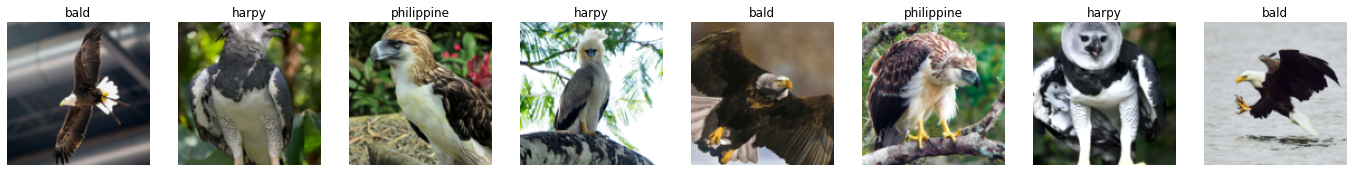

In [21]:
dls.valid.show_batch(max_n=8, nrows=1)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


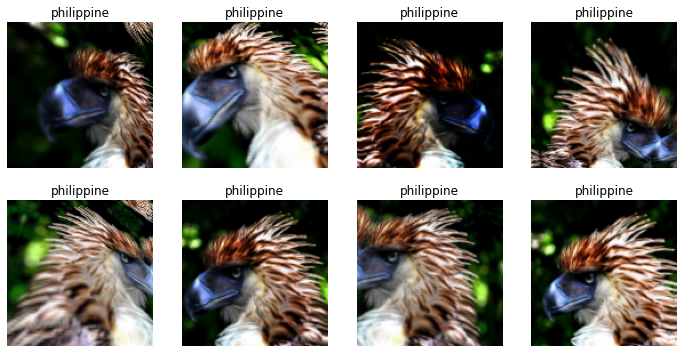

In [22]:
eagles = eagles.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = eagles.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [23]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.543618,1.056827,0.241379,00:21


epoch,train_loss,valid_loss,error_rate,time
0,0.713854,0.342363,0.103448,00:22
1,0.564728,0.238924,0.057471,00:21
2,0.442915,0.249382,0.057471,00:21
3,0.371320,0.242214,0.057471,00:22


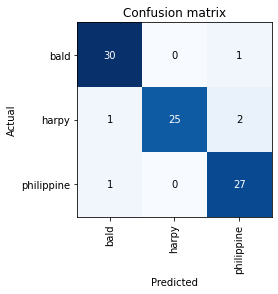

In [24]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

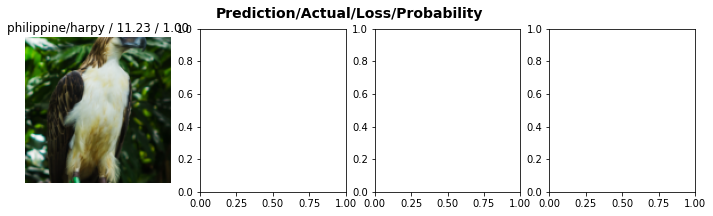

In [25]:
interp.plot_top_losses(4, nrows=1)

In [26]:
learn.export()

In [27]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [28]:
learn_inf = load_learner(path/'export.pkl')

In [29]:
learn_inf.predict('images/harpy.jpg')

('harpy', TensorBase(1), TensorBase([1.4182e-03, 9.9858e-01, 9.9315e-07]))

In [30]:
learn_inf.dls.vocab

['bald', 'harpy', 'philippine']

In [31]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [34]:
img = PILImage.create(btn_upload.data[-1])

In [35]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [36]:
pred,pred_idx,probs = learn_inf.predict(img)
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: harpy; Probability: 0.9992')

In [37]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [38]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [39]:
btn_upload = widgets.FileUpload()

In [40]:
VBox([widgets.Label('Select your eagle!'), 
      btn_upload, btn_run, out_pl, lbl_pred])